In [1]:
import os
import sys
import math
import time
from datetime import datetime

import numpy as np
import cv2
import natsort
import matplotlib.pyplot as plt
import scipy.io

from scipy.spatial import Voronoi, voronoi_plot_2d
from skimage.morphology import skeletonize
# from idaes.core.surrogate.pysmo.sampling import CVTSampling


rng = np.random.default_rng()
GPU_number = 1  # 사용할 물리 GPU 번호
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_number) 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.fft import fft2, ifft2

if not torch.cuda.is_available():
    raise RuntimeError("CUDA가 활성화되지 않았습니다. GPU 환경을 확인하세요.")

device = torch.device("cuda:0")
torch.cuda.set_device(device)

print(f"Using GPU {GPU_number} (as cuda:0): {torch.cuda.get_device_name(0)}")

Using GPU 1 (as cuda:0): NVIDIA RTX A6000


In [2]:
import torch
import torch.fft as fft
import torch.nn.functional as F

import cv2               
import numpy as np
import math
import glob
import natsort

import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage.metrics import structural_similarity as ssim
import time

# import ADMM_Torch_color
from utils_3d_recon import *


### Functions

In [3]:
import torch 
def center_crop(img, center=None, size=(0, 0), mode="crop", **kwargs):
    """
    Crop the input image based on the center and size.
    
    Parameters:
    - img: Input image (numpy array or torch tensor)
    - center: Center coordinates for cropping
    - size: Size of the cropped region
    - mode: Cropping mode ("crop", "same", "center")
    
    Returns:
    - output: Cropped image
    """
    if torch.is_tensor(img):
        return center_crop_t(img, center=center, size=size, mode=mode, **kwargs)
    else:
        return center_crop_n(img, center=center, size=size, mode=mode, **kwargs)

def center_crop_n(img, center=None, size=(0, 0), mode="crop"):
    """
    Crop numpy array based on the center and size.
    
    Parameters:
    - img: Input numpy array
    - center: Center coordinates for cropping
    - size: Size of the cropped region
    - mode: Cropping mode ("crop", "same", "center")
    
    Returns:
    - output: Cropped numpy array
    """
    img_h, img_w = np.shape(img)[:2]
    crop_h, crop_w = size
    crop_h_half, crop_h_mod = divmod(crop_h, 2)
    crop_w_half, crop_w_mod = divmod(crop_w, 2)

    if center is None:
        crop_center_h = img_h // 2
        crop_center_w = img_w // 2
    else:
        crop_center_h, crop_center_w = center

    if mode == "crop":
        output = img[crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
                     crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod, ...]
    elif mode == "same":
        output = np.zeros_like(img)
        output[crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
               crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod, ...] = img[
            crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
            crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod, ...
        ]
    elif mode == "center":
        output = np.zeros_like(img)
        output[img_h - crop_h_half: img_h + crop_h_half + crop_h_mod,
               img_w - crop_w_half: img_w + crop_w_half + crop_w_mod, ...] = img[
            crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
            crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod, ...
        ]
    return output

def center_crop_t(img, center=None, size=(0, 0), mode="crop"):
    """
    Crop torch tensor based on the center and size.
    
    Parameters:
    - img: Input torch tensor
    - center: Center coordinates for cropping
    - size: Size of the cropped region
    - mode: Cropping mode ("crop", "same", "center")
    
    Returns:
    - output: Cropped torch tensor
    """
    img_h, img_w = img.size()[-2:]
    crop_h, crop_w = size
    crop_h_half, crop_h_mod = divmod(crop_h, 2)
    crop_w_half, crop_w_mod = divmod(crop_w, 2)

    if center is None:
        crop_center_h = img_h // 2
        crop_center_w = img_w // 2
    else:
        crop_center_h, crop_center_w = center

    if mode == "crop":
        output = img[..., crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
                    crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod]
    elif mode == "same":
        output = torch.zeros_like(img)
        output[..., crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
               crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod] = img[
            ..., crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
            crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod
        ]
    elif mode == "center":
        output = torch.zeros_like(img)
        output[..., img_h - crop_h_half: img_h + crop_h_half + crop_h_mod,
               img_w - crop_w_half: img_w + crop_w_half + crop_w_mod] = img[
            ..., crop_center_h - crop_h_half: crop_center_h + crop_h_half + crop_h_mod,
            crop_center_w - crop_w_half: crop_center_w + crop_w_half + crop_w_mod
        ]
    return output

In [4]:
def run_generator(psf, scene, save_dir=False, color=True):

    sensor_size = psf.shape
    sen_H, sen_W = sensor_size[0], sensor_size[1]
    padded_size = tuple(2 * x for x in psf.shape)

    scene_H, scene_W = scene.shape[0], scene.shape[1]

    if scene_H > sen_H or scene_W > sen_W:
        H_ratio = scene_H / sen_H
        W_ratio = scene_W / sen_W

        if H_ratio >= W_ratio:
            resize_W = int(np.ceil(scene_W / H_ratio))
            scene = cv2.resize(
                scene.to("cpu").numpy(),
                (resize_W, sen_H),
                interpolation=cv2.INTER_LINEAR,
            )
        else:
            resize_H = int(np.ceil(scene_H / W_ratio))
            scene = cv2.resize(
                scene.to("cpu").numpy(),
                (sen_W, resize_H),
                interpolation=cv2.INTER_LINEAR,
            )

        scene = torch.from_numpy(scene).to(device)

    psf_pad = norm_8bit_tensor(img_pad(psf, padded_size))
    scene_pad = norm_8bit_tensor(img_pad(scene, padded_size))

    #     psf_pad = torch.from_numpy(psf_pad).to(device)
    #     scene_pad = torch.from_numpy(scene_pad).to(device)

    raw = convolve_rgb(psf_pad, scene_pad, color)

    raw = norm_8bit_tensor(img_crop(raw, padded_size, sensor_size)).to("cpu").numpy()
    psf = (
        norm_8bit_tensor(img_crop(psf_pad, padded_size, sensor_size)).to("cpu").numpy()
    )
    scene = (
        norm_8bit_tensor(img_crop(scene_pad, padded_size, sensor_size))
        .to("cpu")
        .numpy()
    )

    # if not save_dir:
        # save_dir = os.path.dirname(__file__) + "/Raw"

    #     cv2.imwrite("{}/psf.png".format(save_dir), psf)
    #     cv2.imwrite("{}/scene.png".format(save_dir), scene)
    #     cv2.imwrite("{}/raw.png".format(save_dir), raw)

    return [psf, scene, raw]


def norm_8bit_tensor(X):
    max_X = torch.max(X)
    if max_X == 0:
        max_X = torch.ones_like(max_X).to(device)
    X = X / max_X * 255
    return X.int()


def convolve_rgb(psf_pad, scene_pad, color=True):
    scene_fft = fft.fftn(scene_pad, dim=(0, 1))
    psf_fft = fft.fftn(psf_pad, dim=(0, 1))
    if color:
        psf_fft = torch.repeat_interleave(psf_fft.unsqueeze(-1), 3, 2)
    return torch.abs(
        fft.ifftshift(fft.ifftn(scene_fft * psf_fft, dim=(0, 1)), dim=(0, 1))
    )

def img_pad(b, full_size):
    v_pad = int(np.ceil(abs(full_size[0] - b.shape[0]) // 2))
    h_pad = int(np.ceil(abs(full_size[1] - b.shape[1]) // 2))
    if b.ndim == 3:
        out = f.pad(b, (0, 0, h_pad, h_pad, v_pad, v_pad))
        return out[:full_size[0], :full_size[1], :]
    else:
        out = f.pad(b, (h_pad, h_pad, v_pad, v_pad))
        return out[:full_size[0], :full_size[1]]
    
def img_crop(M, full_size, sensor_size):
    top = (full_size[0] - sensor_size[0]) // 2
    bottom = (full_size[0] + sensor_size[0]) // 2
    left = (full_size[1] - sensor_size[1]) // 2
    right = (full_size[1] + sensor_size[1]) // 2
    if len(M.shape)==3:
        return M[top:bottom,left:right,:]
    else:
        return M[top:bottom,left:right]
    
def center_crop(img, center, size):
    Hc, Wc = center
    H, W = size
    H2, Hm = divmod(H, 2)
    W2, Wm = divmod(W, 2)
    img_cropped = img[Hc - H2 : Hc + H2 + Hm, Wc - W2 : Wc + W2 + Wm, ...]
    return img_cropped
    
def norm_8bit(X):
    max_X = X.max()
    if max_X == 0:
        max_X = 1
    A = X / max_X * 255
    return A.astype('uint8')

def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

# from skimage.metrics import structural_similarity as ssim

def print_file_with_num(img_list):
    for i in range(len(img_list)):
        print(i, img_list[i])
    return

## 현재 위치

In [5]:
os.getcwd()

'/home/hotdog/sample/25AIOBIO/_Recon3d/notebook'

### Preprocessing

In [6]:
# psf_path = "/mnt/NAS/Grants/25_AIOBIO/experiment/251114/Center_Align/Color/psf_centered"
# psf_path = "/mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/bg_subtracted_centered"
psf_path = "/mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/"
psf_list = natsort.natsorted((glob.glob(psf_path + "/*.png")), reverse=False)
print_file_with_num(psf_list)

0 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p0.png
1 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p1.png
2 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p2.png
3 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p3.png
4 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p4.png
5 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p5.png
6 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p6.png
7 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p7.png
8 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p8.png
9 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p9.png
10 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/7p0.png
11 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/7p1.png
12 /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/7p2.png
13 /mnt/NAS/Grants/25_AIOBIO/experi

In [7]:
import os
import cv2
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

psf_dir = "/mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/bg_subtracted_centered"

# psf_dir = "/mnt/NAS/Grants/25_AIOBIO/experiment/251114/psf"

desired_wds = np.array([
    6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9,
    7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9,
    8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9,
    9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9,
    10.0
])
desired_wds_set = set(desired_wds.tolist())


psf_list = [
    os.path.join(psf_path, f)
    for f in os.listdir(psf_path)
    if f.endswith(".png")
]

# selected = []
# for p in psf_list:
#     fname = os.path.basename(p)        
#     stem, ext = os.path.splitext(fname)    ## 파일명 : 6.0.png
    
#     try:
#         wd = float(stem) 
#     except ValueError:
#         continue

#     if wd in desired_wds_set:
#         selected.append((wd, p))

selected = []
for p in psf_list:
    fname = os.path.basename(p)        
    stem, ext = os.path.splitext(fname)
        
    stem_float_str = stem.replace("p",".")  ##  파일명 : 6p0.png
    
    try:
        wd = float(stem_float_str) 
    except ValueError:
        continue

    if wd in desired_wds_set:
        selected.append((wd, p))
        
        
        
        
selected = sorted(selected, key=lambda x: x[0])

print("선택된 PSF 경로:")
for wd, path in selected:
    print(f"WD={wd:3.1f} mm -> {path}")

if not selected:
    raise RuntimeError("선택된 PSF가 없습니다. 파일 이름/경로를 확인하세요.")

psfs_np = []
for wd, p in selected:
    psf = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if psf is None:
        raise FileNotFoundError(f"Cannot read image: {p}")
    psf = psf.astype(np.float32)
    psf = np.expand_dims(psf, axis=2)  
    psfs_np.append(psf)

psfs_np = np.concatenate(psfs_np, axis=2)  
psfs = torch.from_numpy(psfs_np).to(device)

print("psfs shape (H, W, N):", psfs.shape)
print("device:", psfs.device)


선택된 PSF 경로:
WD=6.0 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p0.png
WD=6.1 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p1.png
WD=6.2 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p2.png
WD=6.3 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p3.png
WD=6.4 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p4.png
WD=6.5 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p5.png
WD=6.6 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p6.png
WD=6.7 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p7.png
WD=6.8 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p8.png
WD=6.9 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/6p9.png
WD=7.0 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/renamed/cropped/7p0.png
WD=7.1 mm -> /mnt/NAS/Grants/25_AIOBIO/experiment/251

## PSF mat 파일 저장(파일명)

In [8]:
matsave = False
if matsave == True:
    import scipy.io as io
    io.savemat("/mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/41psf_1800x1800_color_new_psf_center_6.0_10.0.mat", {'psf_stack': psfs.detach().cpu().numpy()})

### Run ADMM

In [9]:
import sys
from importlib import reload
from admm_3d_3dtvz_torch import *
# from admm_3d_3dtvz_torch_250211 import *

In [10]:
# Config List
config_list = {
    # IMG, PSF data
    'path_ref': 0,  # 1: start from '~' 0:current or abs path
    'psf_file': "/mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/41psf_1800x1800_color_new_psf_center_6.0_10.0.mat", 
    # 'img_file' : "/mnt/NAS/Grants/25_AIOBIO/experiment/251114/raw/inpaint/cropped/7.png",
    'img_file': "/mnt/NAS/Grants/25_AIOBIO/experiment/251204/inpaint/cropped/270_7p0.png",
    # 'img_file' : "/mnt/NAS/Grants/25_AIOBIO/experiment/251114/Center_Align/Color/raw_centered/Interpolate/crop_1700_color/6/06.png", 

    
    ###Save setup
    'save_dir': "/mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/",
    'save_fig': True,
    
    # Data Setup
    'color_to_process': "mono",  # 'red','green','blue', or 'mono'. If raw file is mono, this is ignored
    'image_bias': 0,  # If camera has bias, subtract from measurement file.
    'psf_bias': 0,  # if PSF needs sensor bias removed, put that here.
    'raw_bias': 0,
    'lateral_downsample': 2,  # down sample image
    'axial_downsample': 1,  # Axial averageing of impulse stack. Must be multiple of 2 and >= 1.
    'start_z': 0,  # First plane to reconstruct. 1 indexed, as is tradition.
    'end_z': 0,  # Last plane to reconstruct. If set to 0, use last plane in file.
    
    # GPU setup
    'useGPU': True,
    'numGPU': 0,
    
    # Recon Parameters
    'max_iter': 400,  # Maximum iteration count  Default: 200
    'disp_figs': 200,  # If set to 0, never display. If set to N>=1, show every N.
    'print_interval': 20, # Print cost every N iterations. Default 1. If set to 0, don't print.
    'regularizer': '3dtvz',
    
    # Optimization Parameters
    'mu1': 0.1,           # 0.4  0.26
    'mu2': 0.3,           # 0.5  0.68,
    'mu3': 2.0,           # 4.0  3.5
   
    # 'tau': 3.0e-5, 
    'tau': 6.0e-4,        # 6.0e-4
    'tau_z' : 6.0e-6,     # 6.0e-6
    'tau_n': 0.06, 
    
    # Tuning Parameter
    'autotune': 1,  # 1:auto-find mu every step. 0:defined values. If set to N>1, tune for N steps then stop.
    'mu_inc': 1.1,  # Inrement and decrement values for mu during autotune.
    'mu_dec': 1.1,  #
    'resid_tol': 1.5,  # Primal/dual gap tolerance.
    
    # Display setup
    # 'roih': 1000,
    # 'roiw': 1000,
    
    # Slice crop size
    'half_crop' : 150,
    
    'normalize_flag': 1,
    # 'display_norm_method': 'log',
    'beta_z': 10    
}

## Iteration 돌리기

path_ref = 0
psf_file = /mnt/NAS/Grants/25_AIOBIO/experiment/251201_psf/41psf_1800x1800_color_new_psf_center_6.0_10.0.mat
img_file = /mnt/NAS/Grants/25_AIOBIO/experiment/251204/inpaint/cropped/270_7p0.png
save_dir = /mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/
save_fig = True
color_to_process = mono
image_bias = 0
psf_bias = 0
raw_bias = 0
lateral_downsample = 2
axial_downsample = 1
start_z = 0
end_z = 0
useGPU = True
numGPU = 0
max_iter = 400
disp_figs = 200
print_interval = 20
regularizer = 3dtvz
mu1 = 0.1
mu2 = 0.3
mu3 = 2.0
tau = 0.0006
tau_z = 6e-06
tau_n = 0.06
autotune = 1
mu_inc = 1.1
mu_dec = 1.1
resid_tol = 1.5
half_crop = 150
normalize_flag = 1
beta_z = 10
Device:0 selected
cuda:0
iter:0 time:0.650 cost:7637.363 data_fidelity:7583.000 regularizer_penalty:54.363
Primal/Dual v:3.12692 Primal/Dual u:3.33333 Primal/Dual w:0.50000 mu1:0.110 mu2:0.330 mu3:1.818


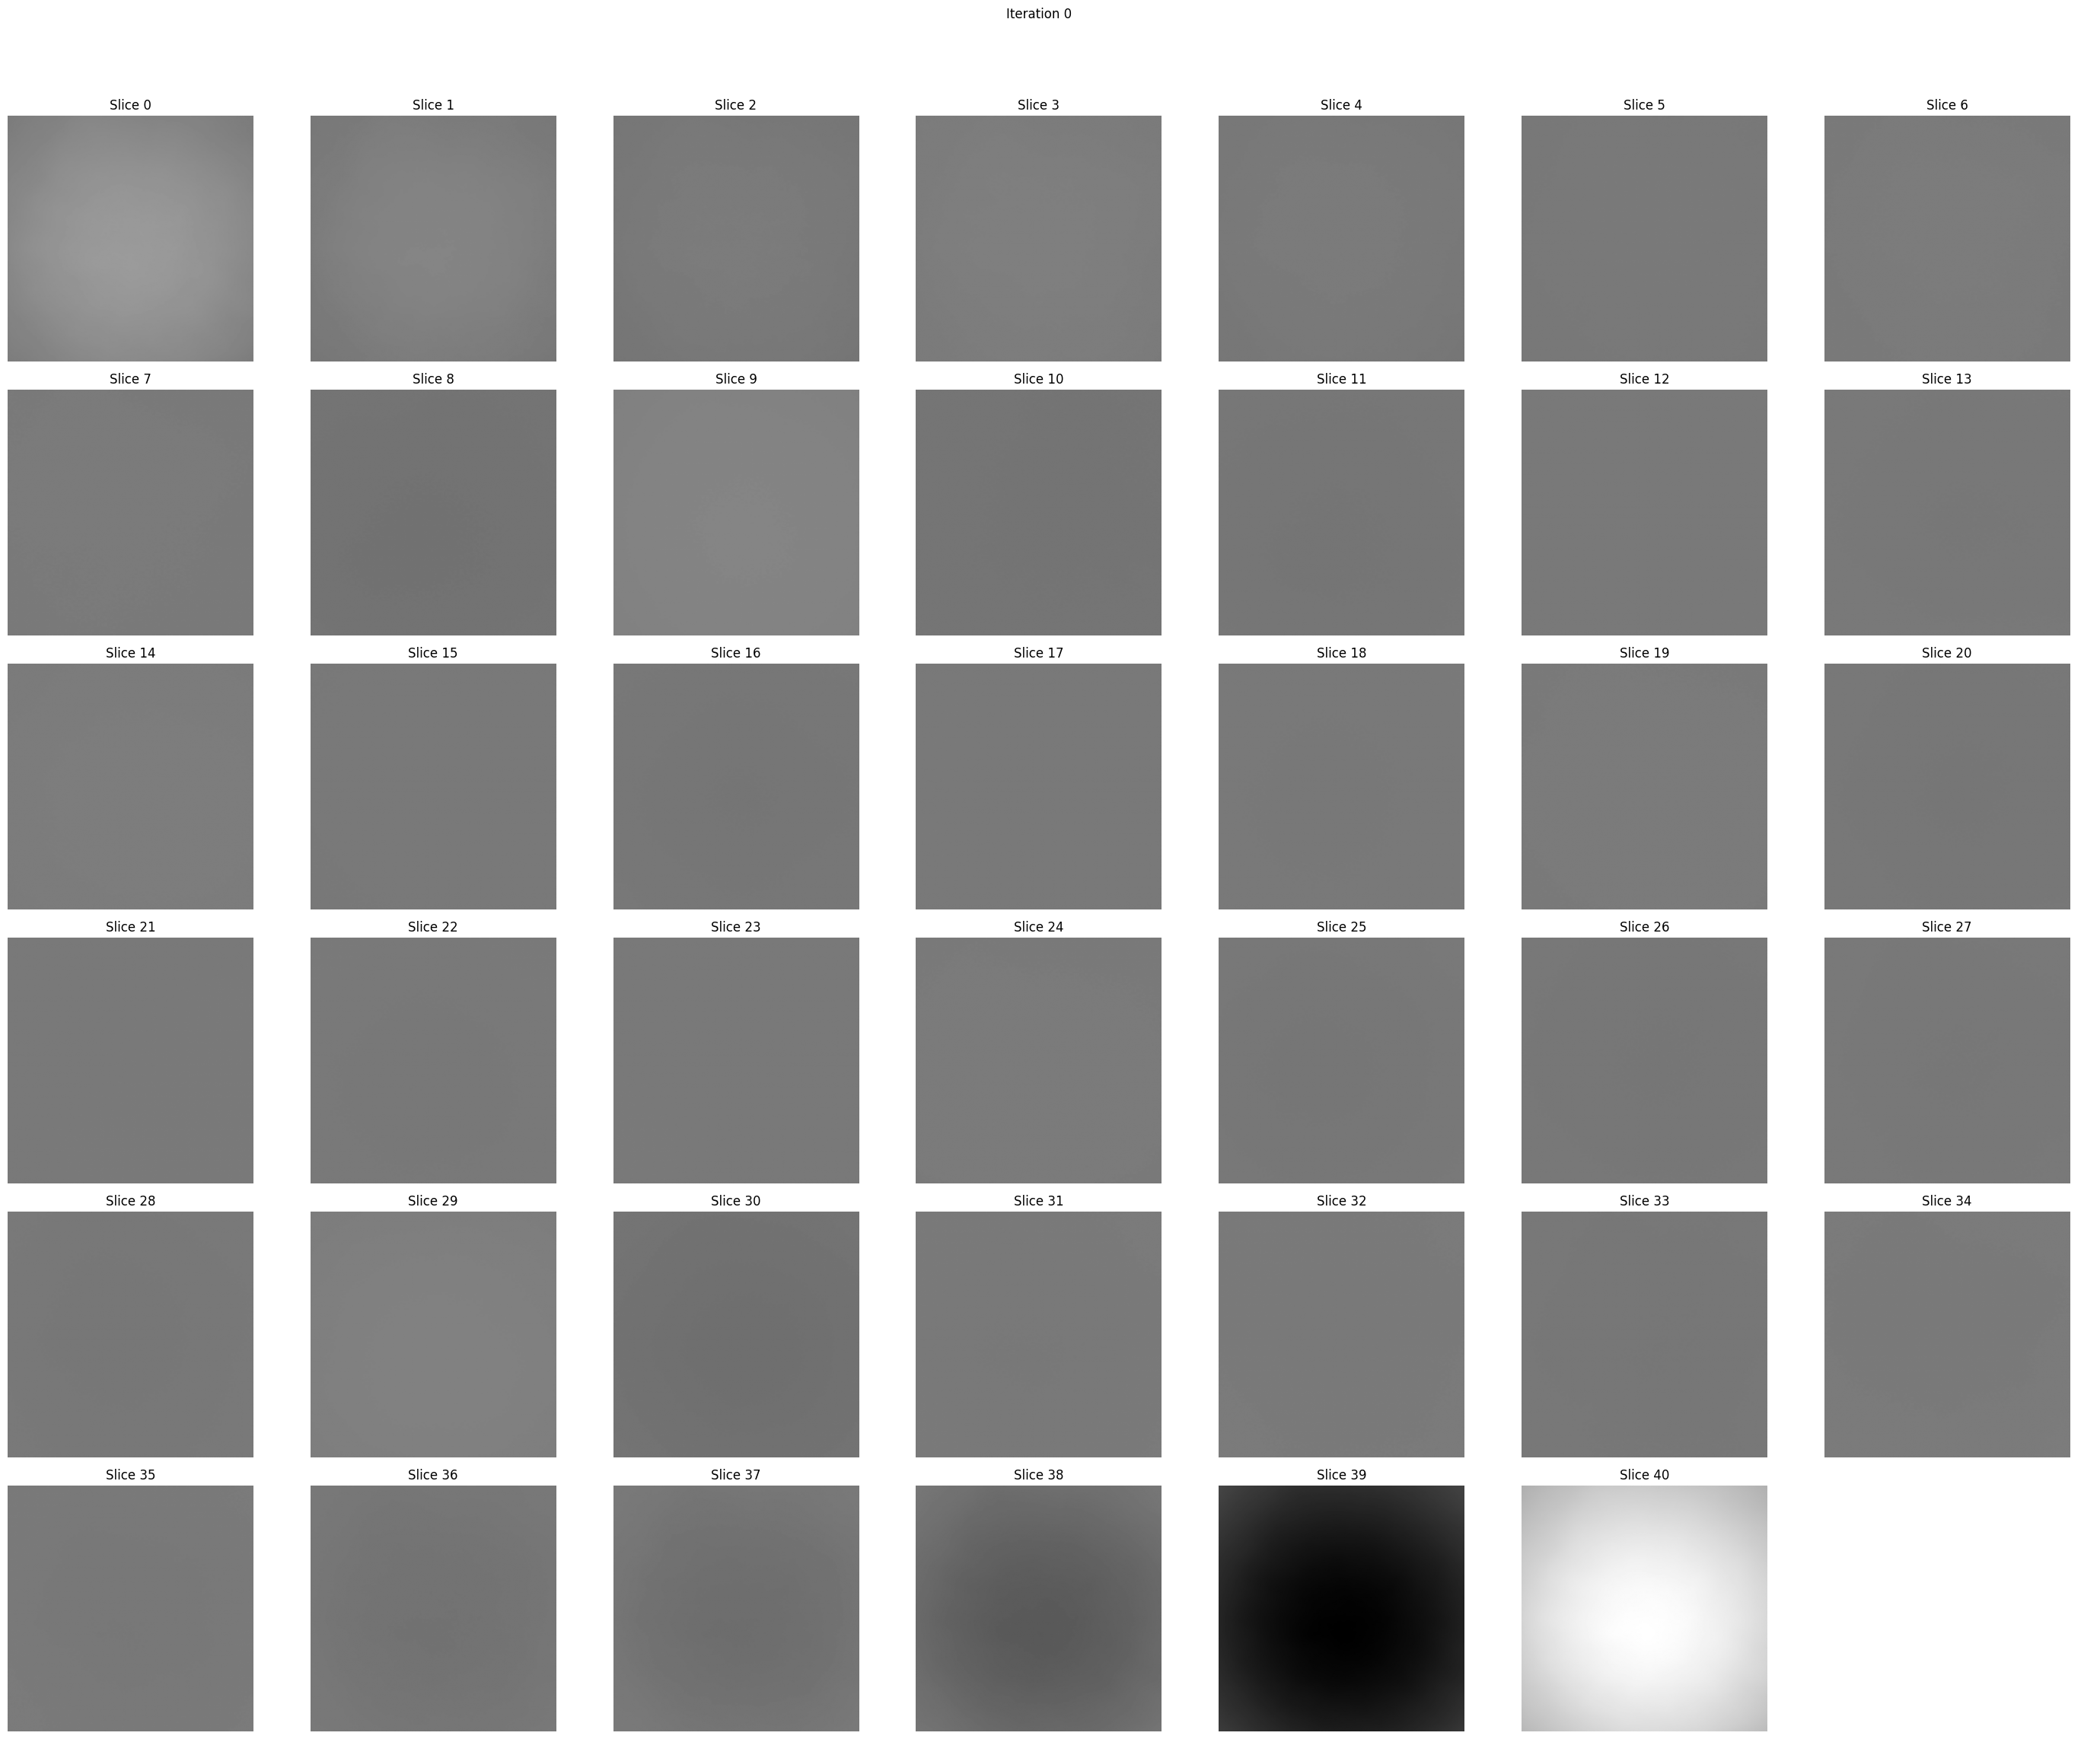

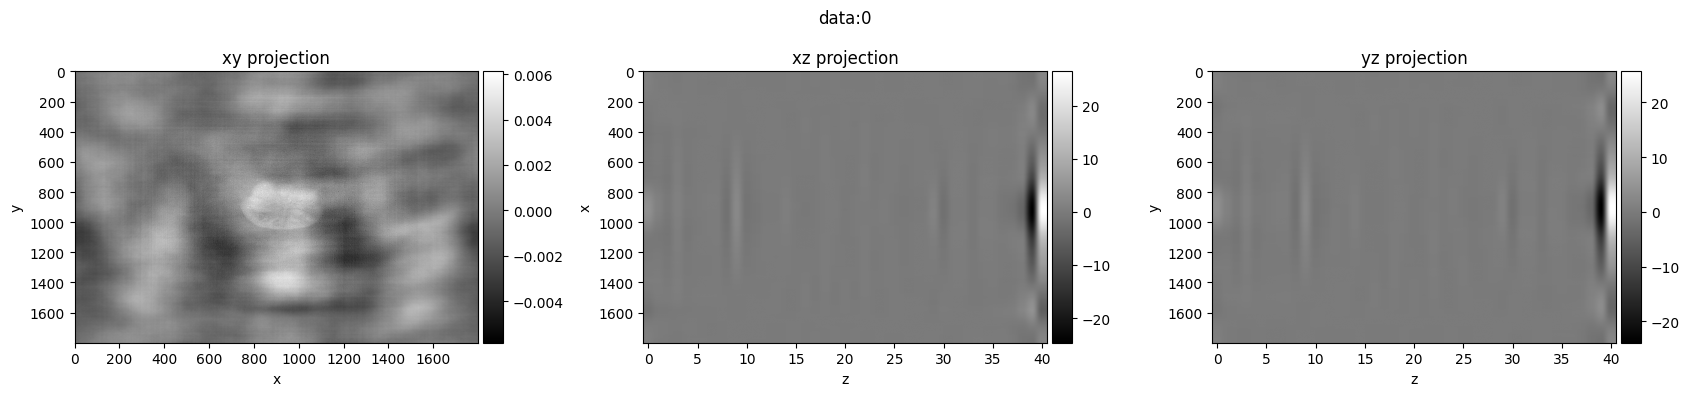

iter:19 time:19.340 cost:342.849 data_fidelity:294.724 regularizer_penalty:48.125
Primal/Dual v:0.73867 Primal/Dual u:1.37755 Primal/Dual w:1.42504 mu1:0.177 mu2:0.399 mu3:2.928
iter:39 time:30.830 cost:290.616 data_fidelity:253.978 regularizer_penalty:36.638
Primal/Dual v:0.68006 Primal/Dual u:1.31726 Primal/Dual w:1.40468 mu1:0.161 mu2:0.399 mu3:3.221
iter:59 time:42.310 cost:213.454 data_fidelity:184.002 regularizer_penalty:29.452
Primal/Dual v:0.82209 Primal/Dual u:1.25282 Primal/Dual w:1.42937 mu1:0.146 mu2:0.399 mu3:3.897
iter:79 time:53.750 cost:169.416 data_fidelity:145.963 regularizer_penalty:23.453
Primal/Dual v:0.70697 Primal/Dual u:1.26656 Primal/Dual w:1.39481 mu1:0.146 mu2:0.399 mu3:3.897
iter:99 time:65.240 cost:162.778 data_fidelity:142.650 regularizer_penalty:20.128
Primal/Dual v:0.79286 Primal/Dual u:1.33107 Primal/Dual w:1.41575 mu1:0.121 mu2:0.399 mu3:4.287
iter:119 time:76.710 cost:171.650 data_fidelity:155.141 regularizer_penalty:16.509
Primal/Dual v:0.77760 Prima

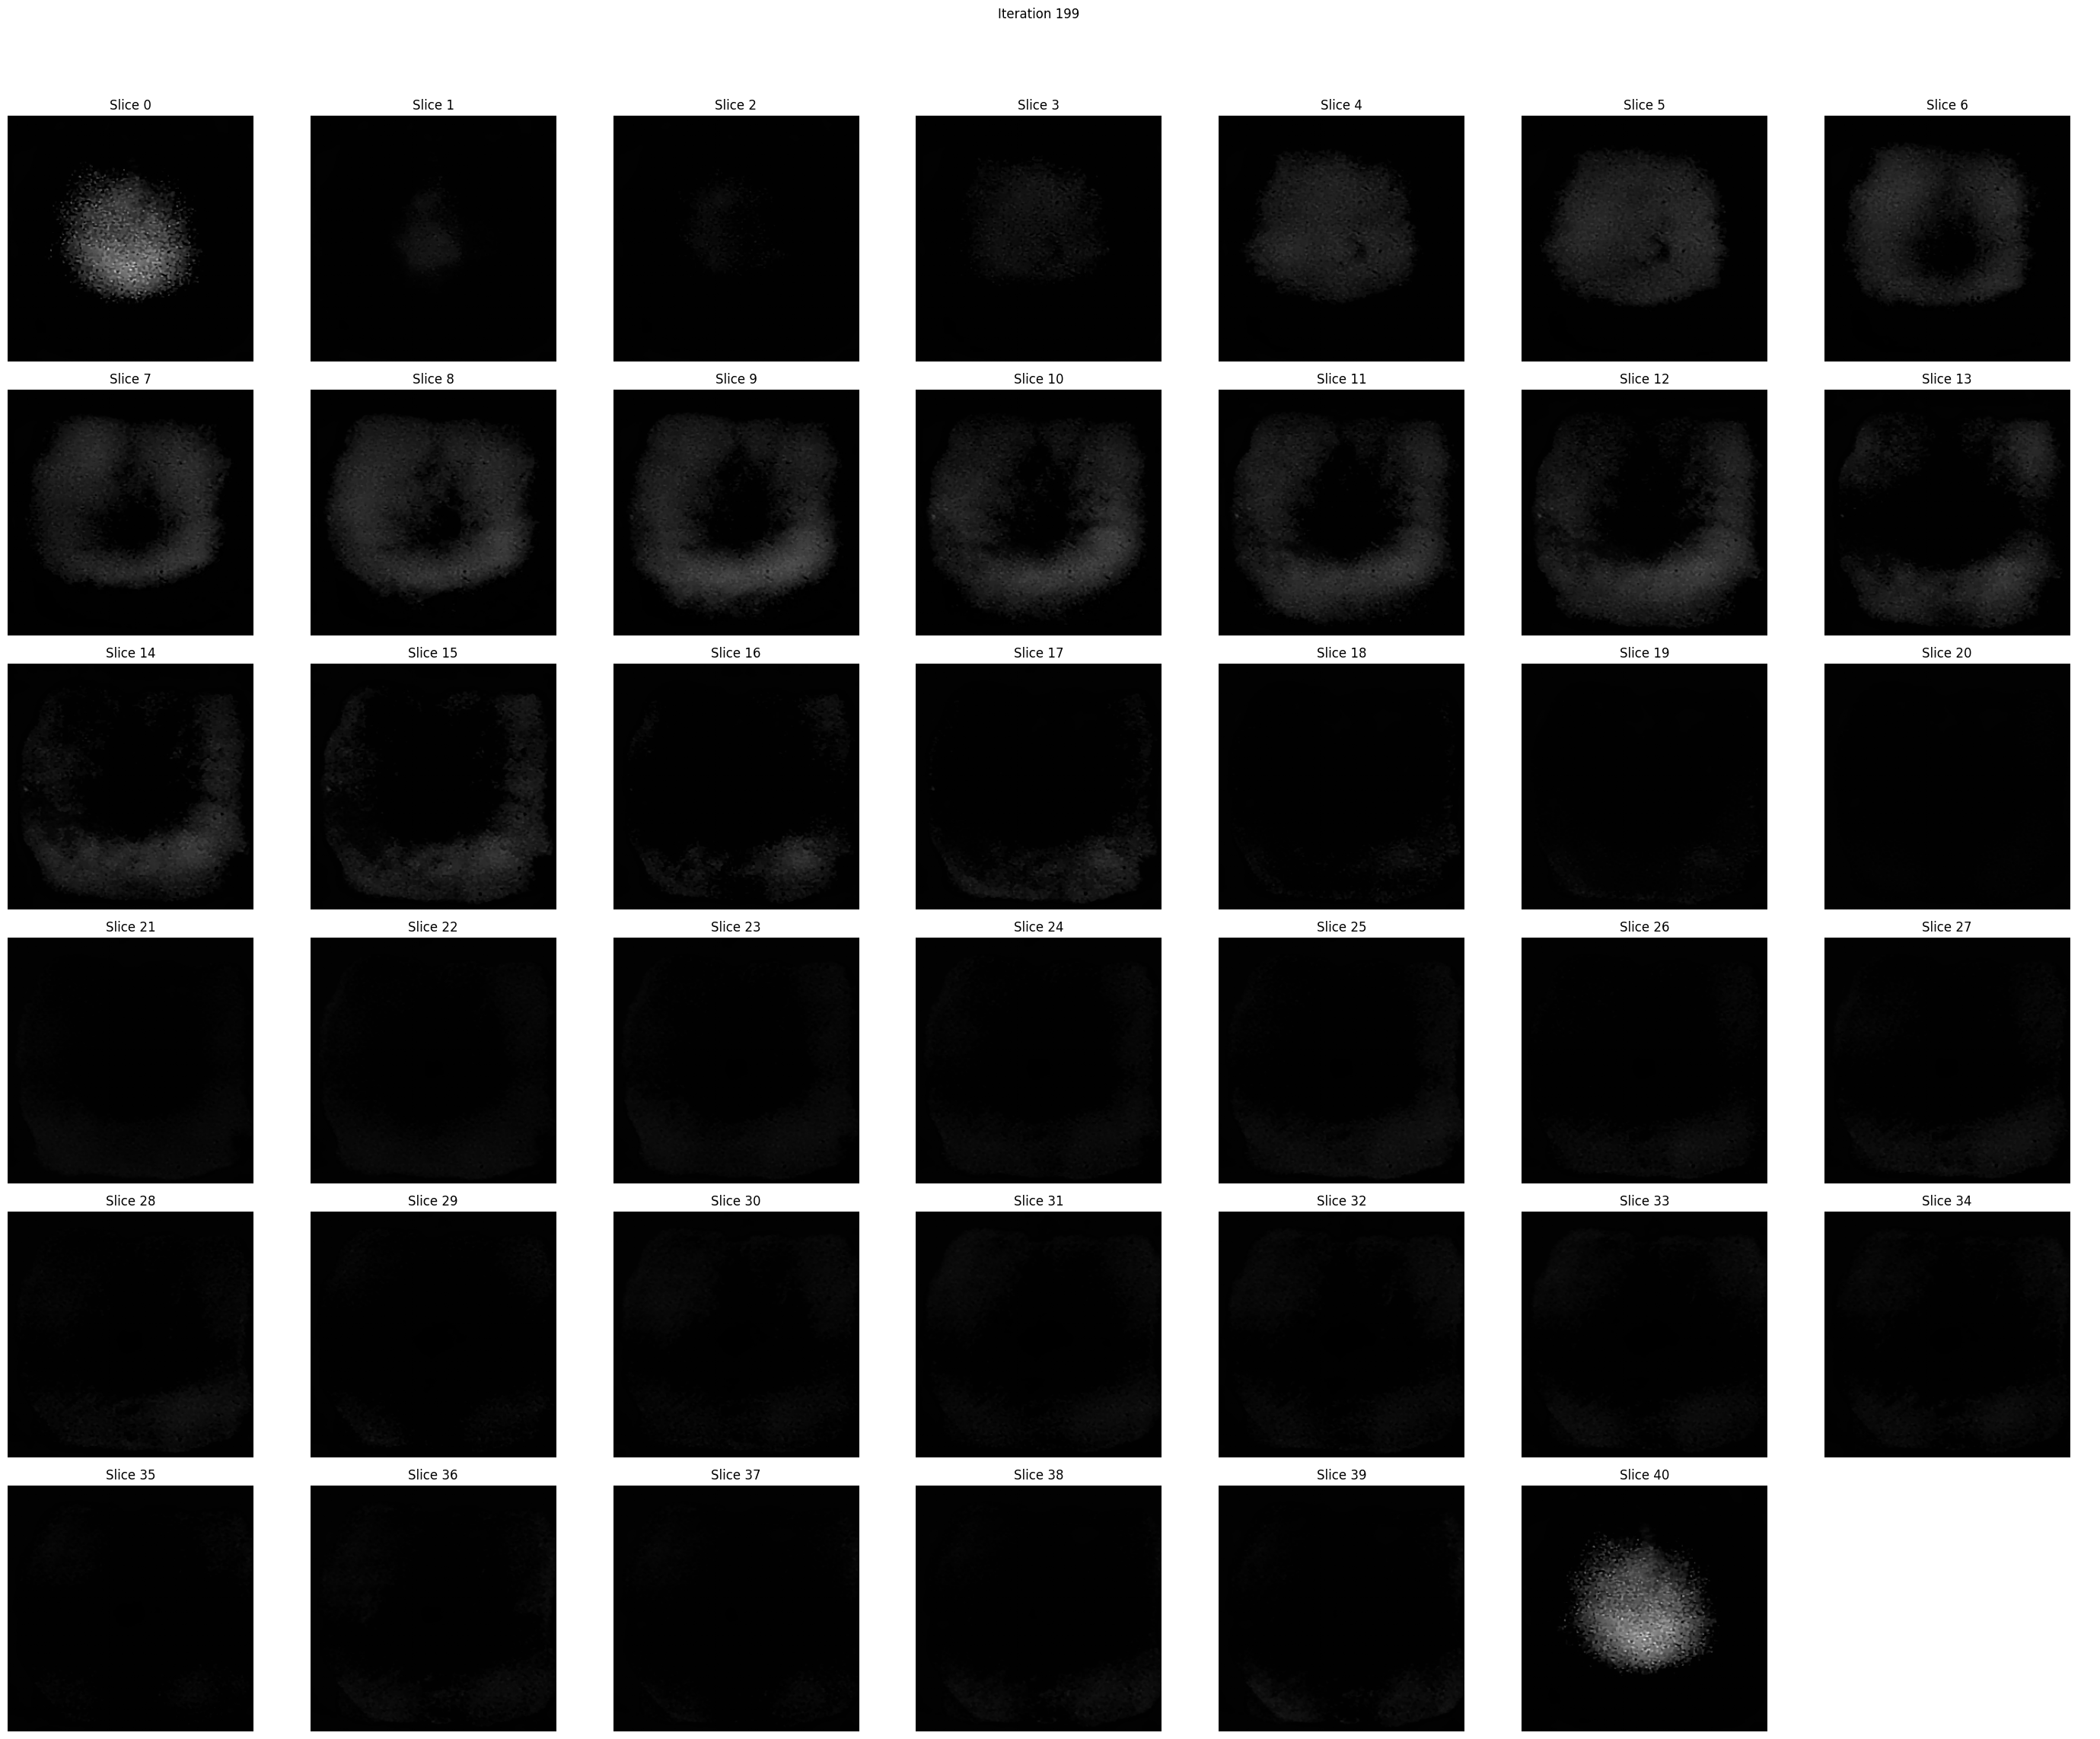

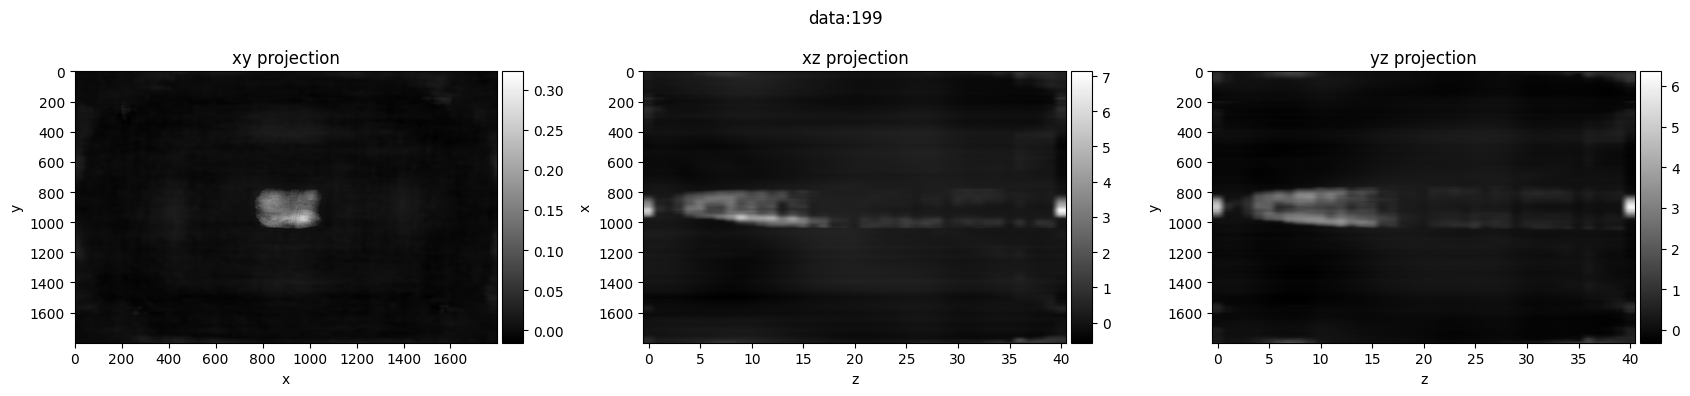

iter:219 time:140.780 cost:501.580 data_fidelity:492.041 regularizer_penalty:9.540
Primal/Dual v:1.03410 Primal/Dual u:1.15442 Primal/Dual w:0.85763 mu1:0.195 mu2:0.439 mu3:5.187
iter:239 time:152.250 cost:554.130 data_fidelity:543.702 regularizer_penalty:10.428
Primal/Dual v:0.97630 Primal/Dual u:1.10219 Primal/Dual w:0.74200 mu1:0.195 mu2:0.439 mu3:5.187
iter:259 time:163.720 cost:535.504 data_fidelity:523.851 regularizer_penalty:11.653
Primal/Dual v:0.99875 Primal/Dual u:1.19391 Primal/Dual w:1.02857 mu1:0.195 mu2:0.439 mu3:5.187
iter:279 time:175.190 cost:512.686 data_fidelity:500.741 regularizer_penalty:11.946
Primal/Dual v:0.71150 Primal/Dual u:1.06975 Primal/Dual w:0.75031 mu1:0.195 mu2:0.439 mu3:5.187
iter:299 time:186.690 cost:493.600 data_fidelity:481.448 regularizer_penalty:12.152
Primal/Dual v:0.86728 Primal/Dual u:1.09017 Primal/Dual w:1.04519 mu1:0.195 mu2:0.439 mu3:5.187
iter:319 time:198.190 cost:483.031 data_fidelity:470.782 regularizer_penalty:12.249
Primal/Dual v:0.7

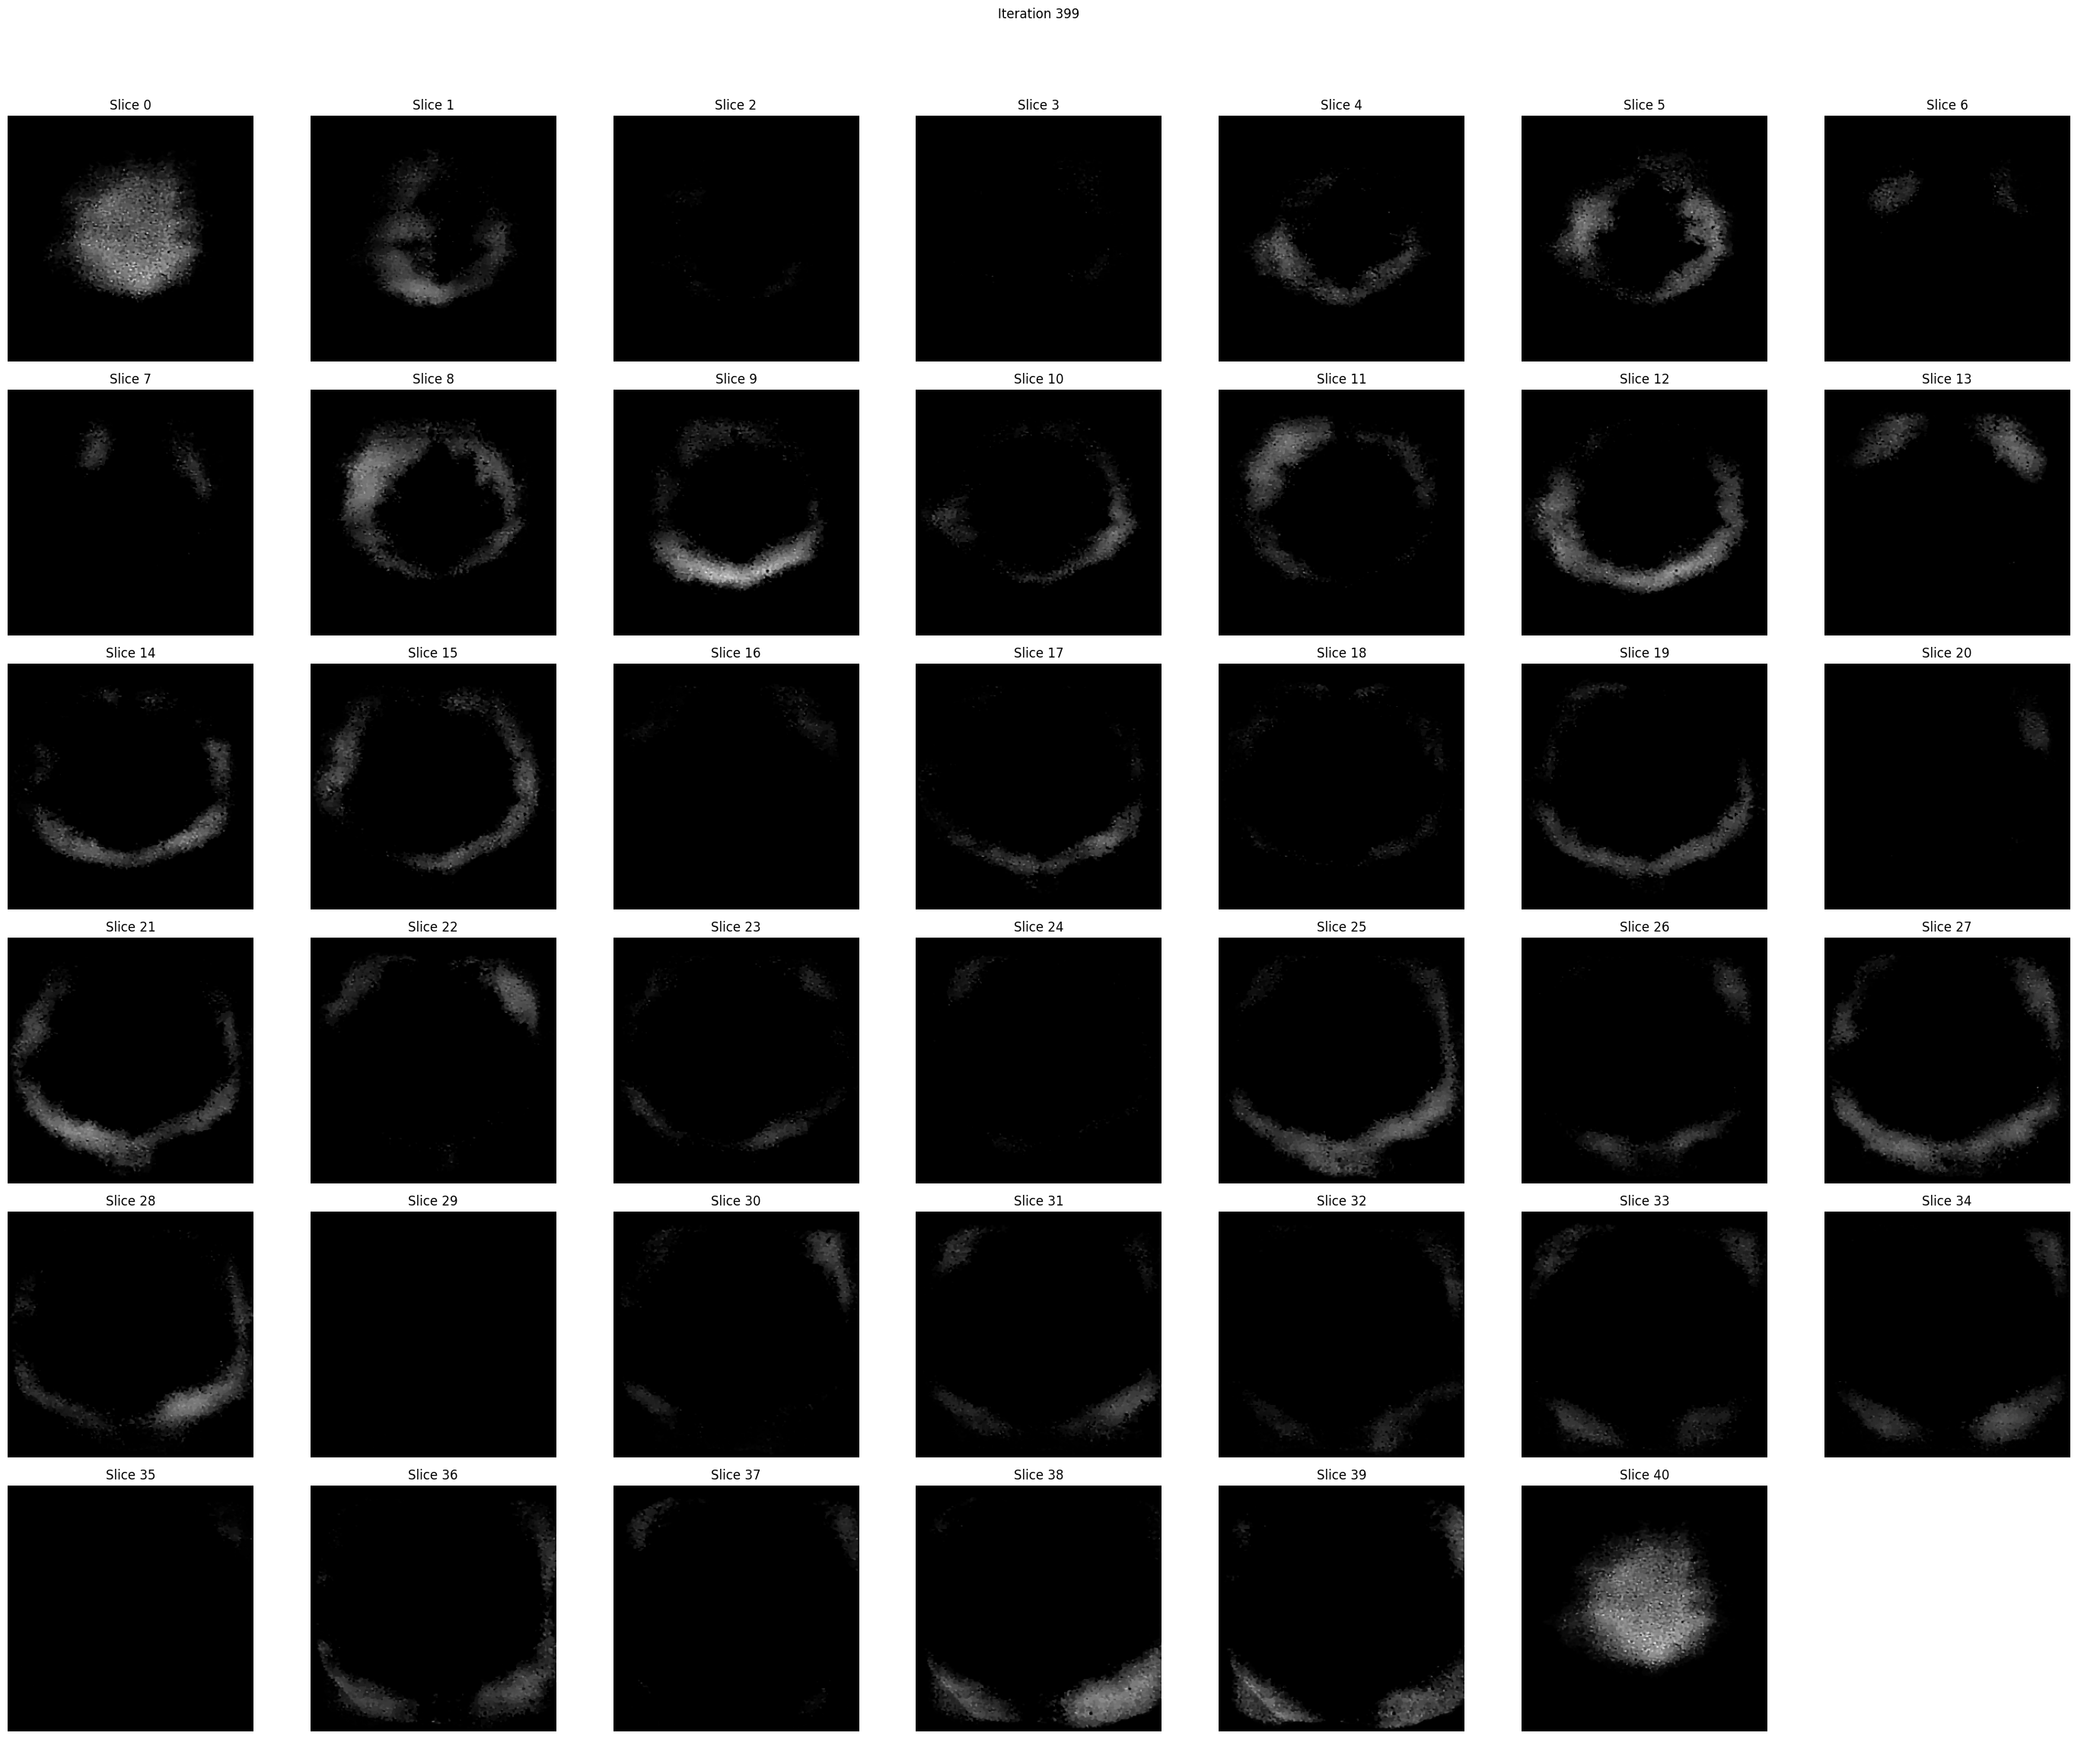

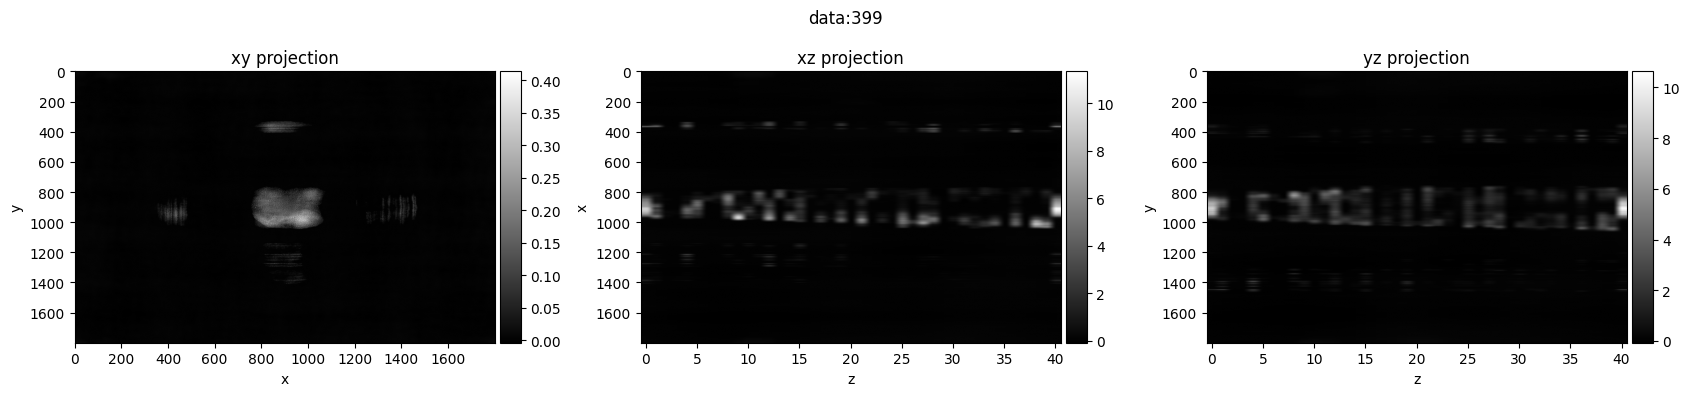

Total elapsed Time: 250.68
Reconstruction Finished!


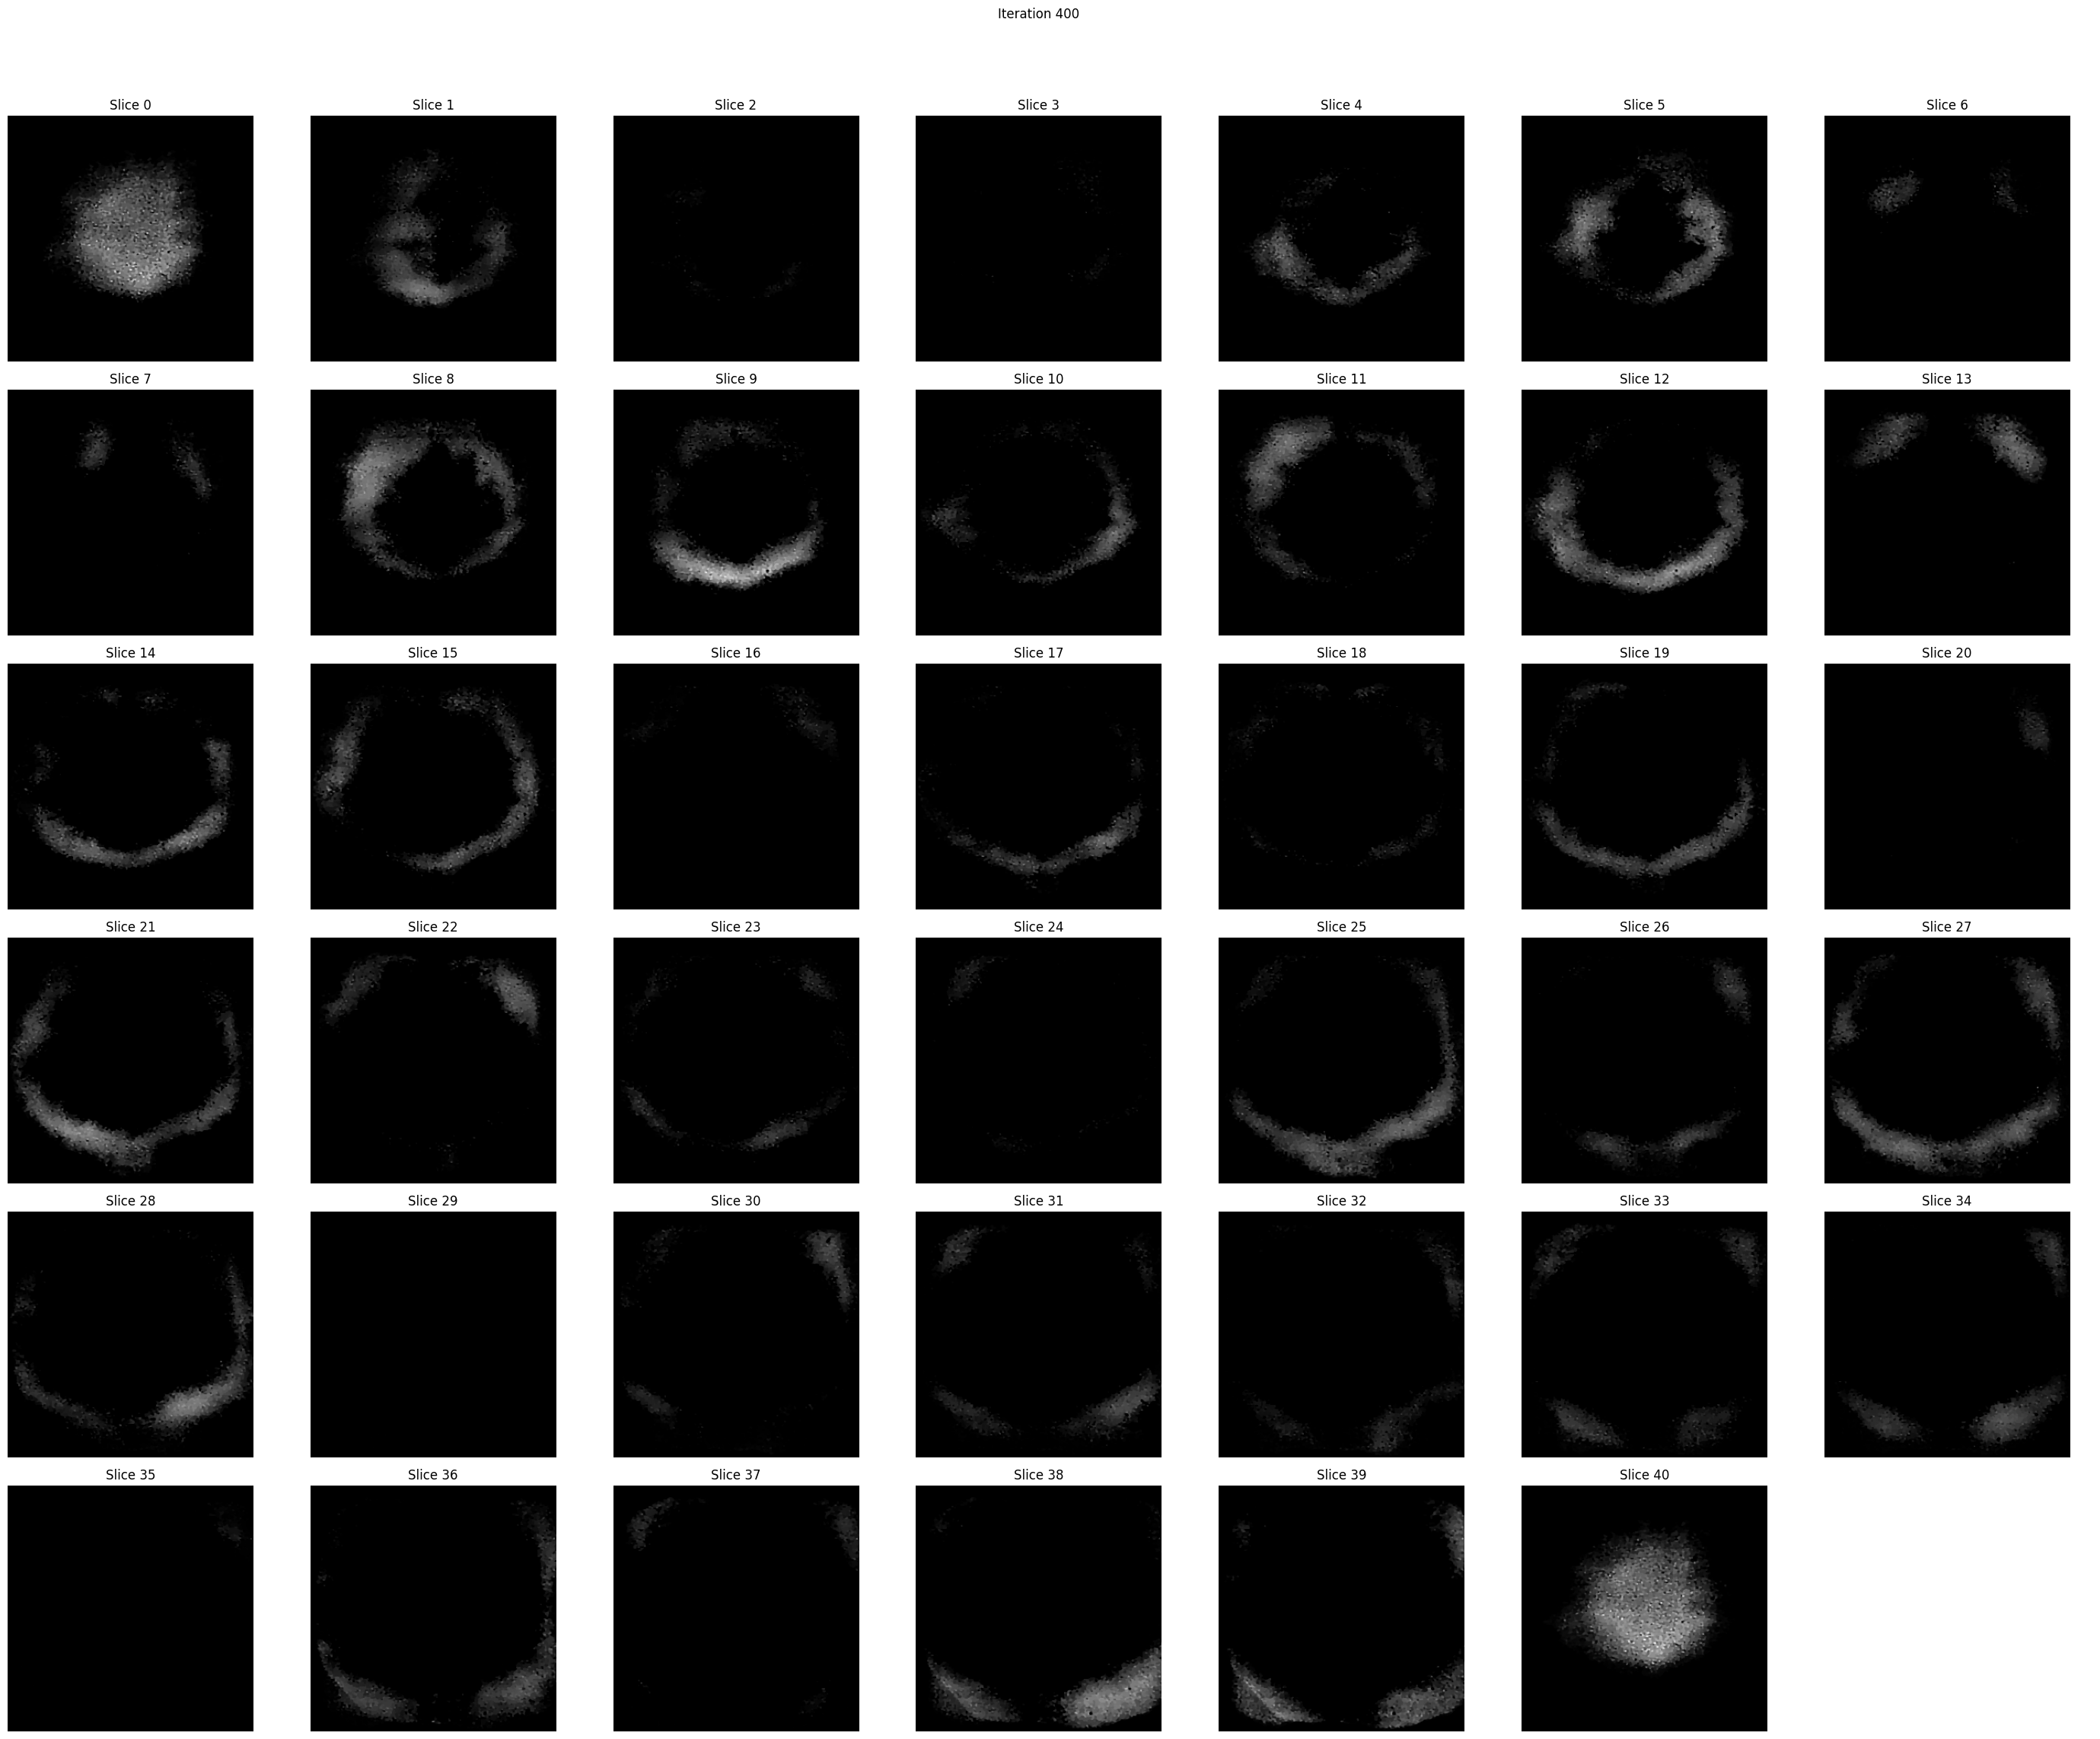

In [11]:
config = config_list
A = ADMM3D(config)
final_im = A.admm()
A.draw_fig(final_im, A.max_iter)

## Iteration 마지막 이미지 확인

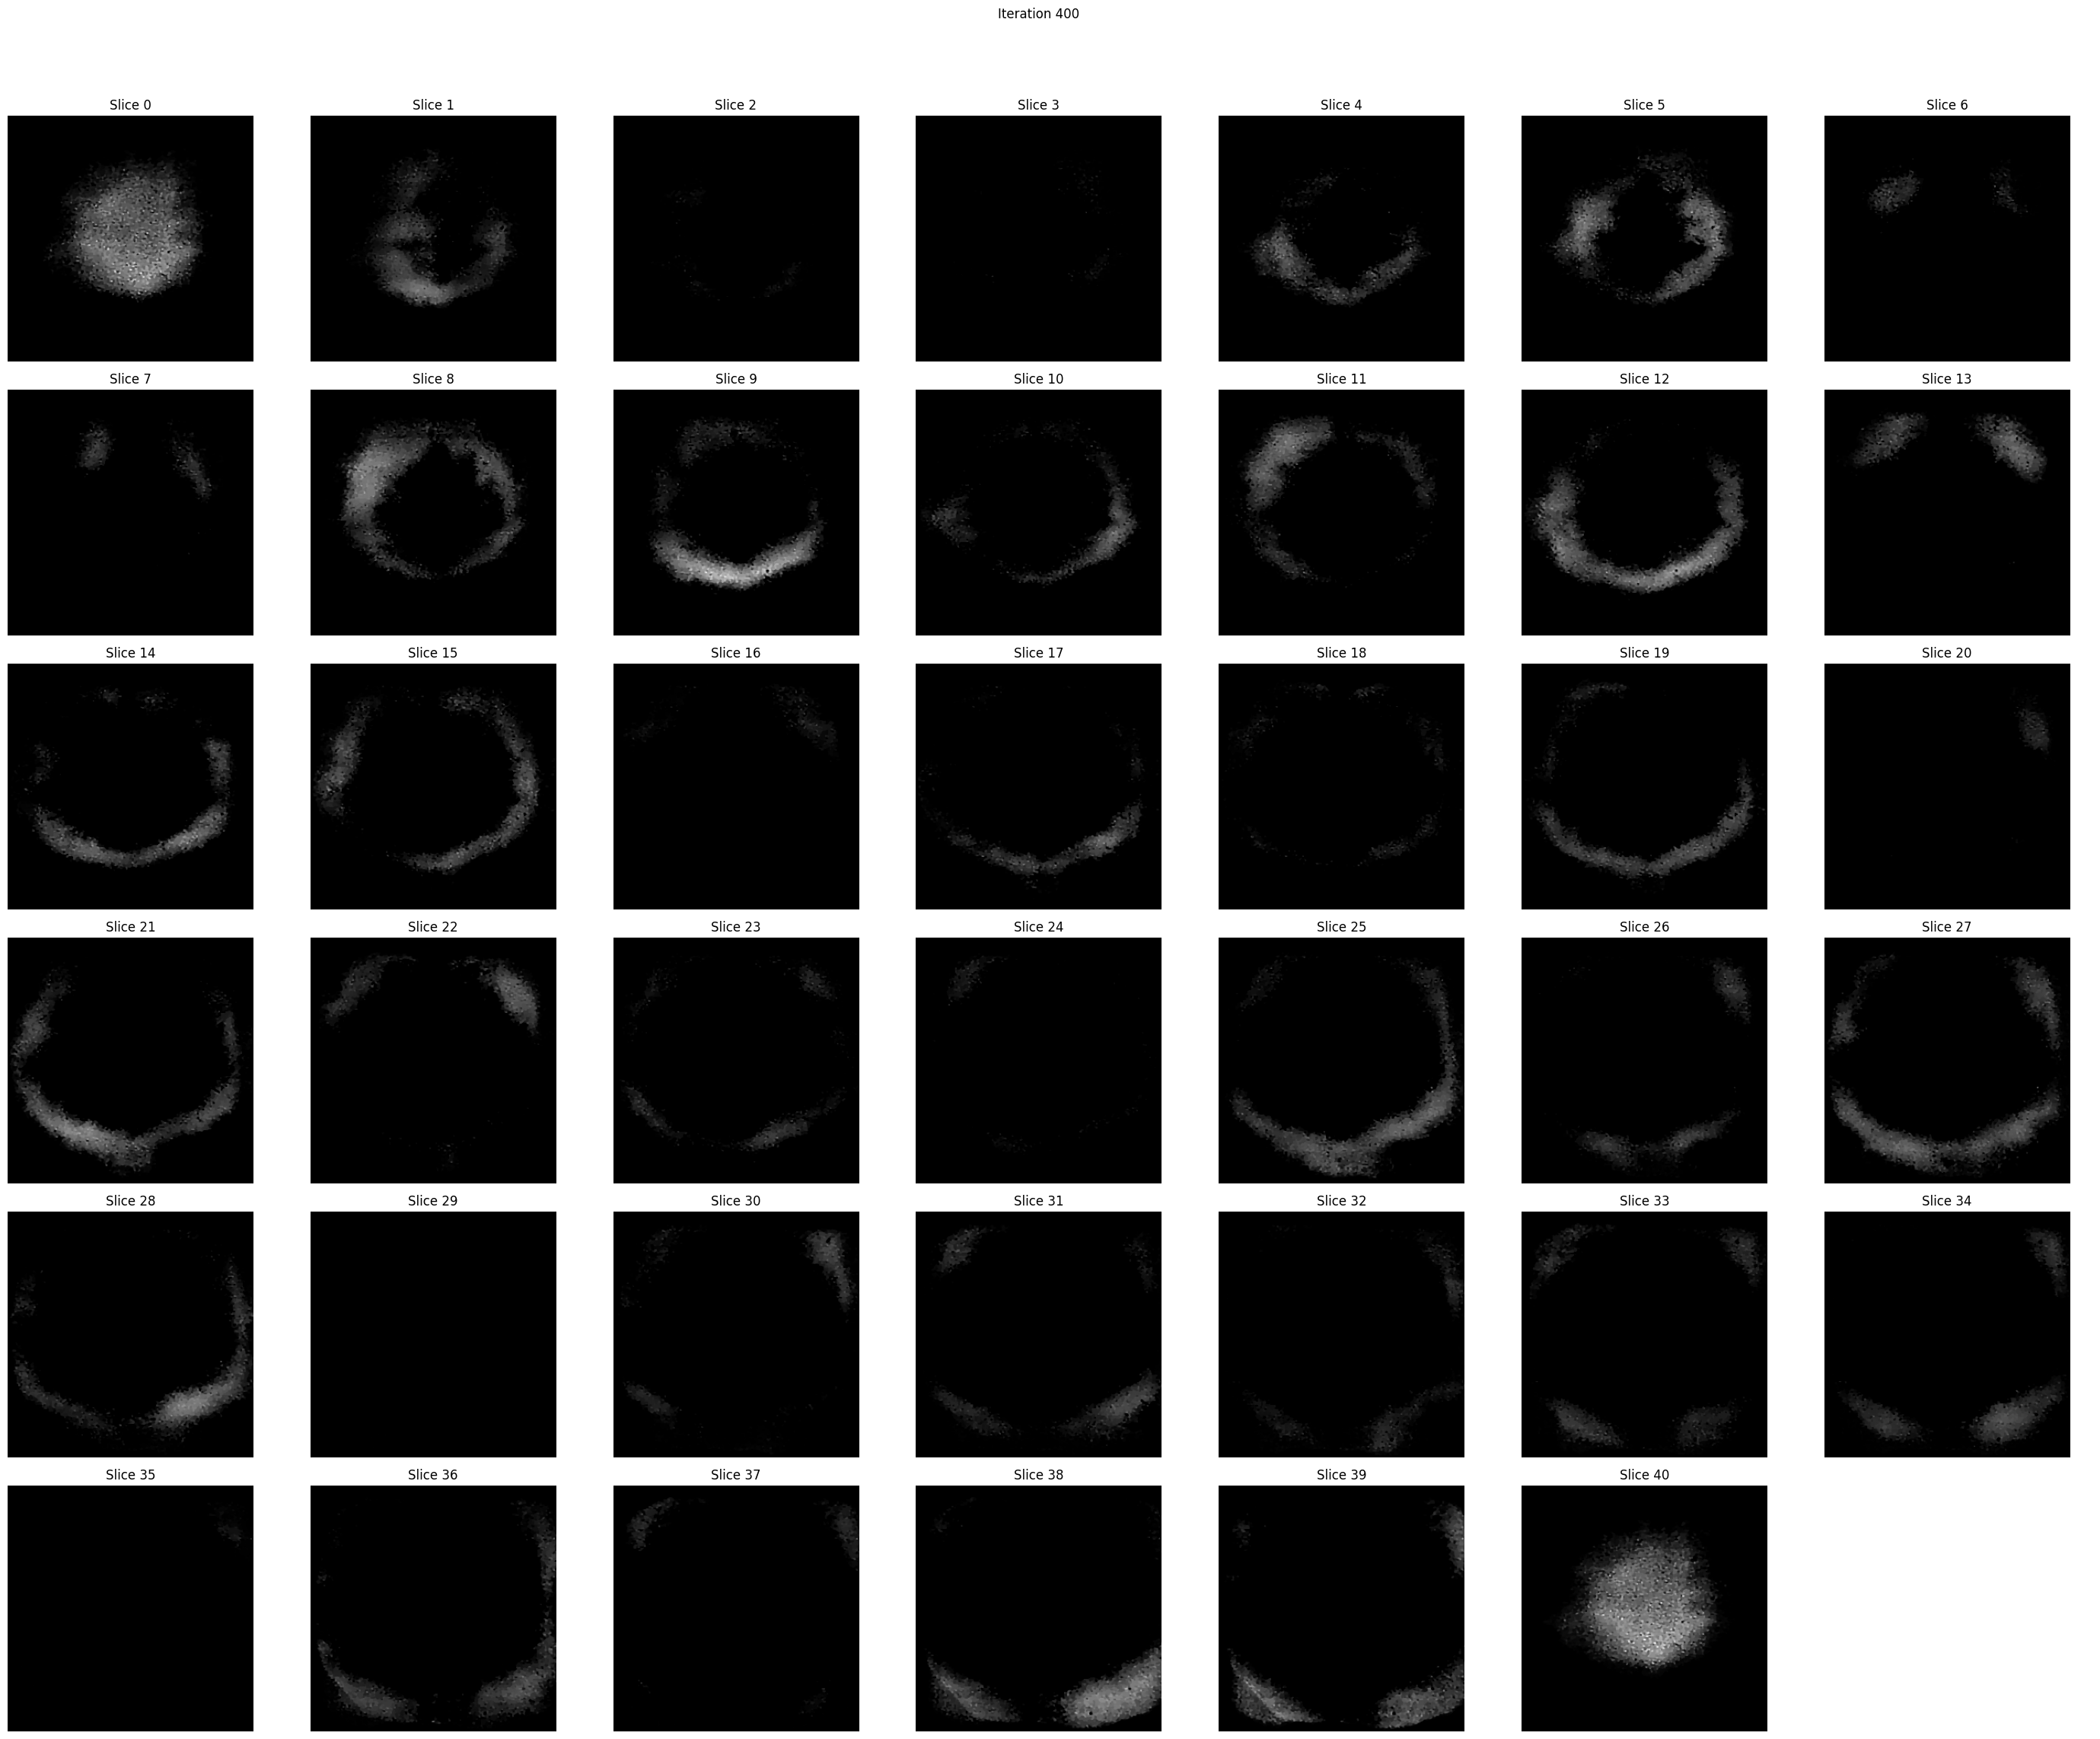

In [12]:
import scipy
final_im = scipy.io.loadmat("/mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/final_data_uncropped.mat")['final']
np.shape(final_im)
A.draw_fig(final_im, A.max_iter)

## Depth별 영역 & 전체 영역에서 Depth별 영역만 색칠했을 때 비교

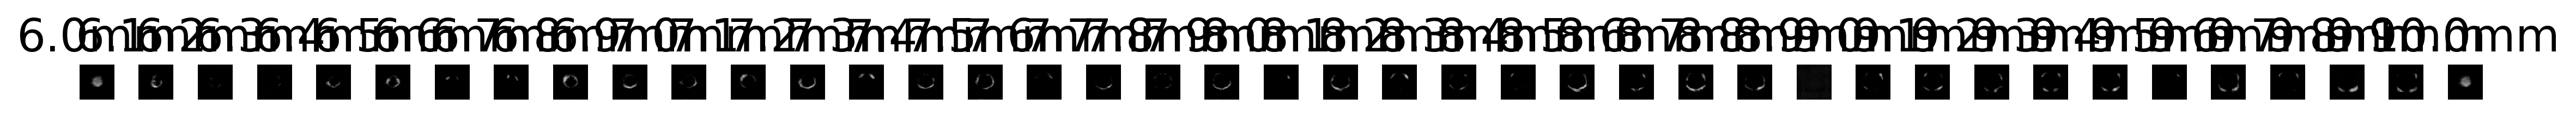

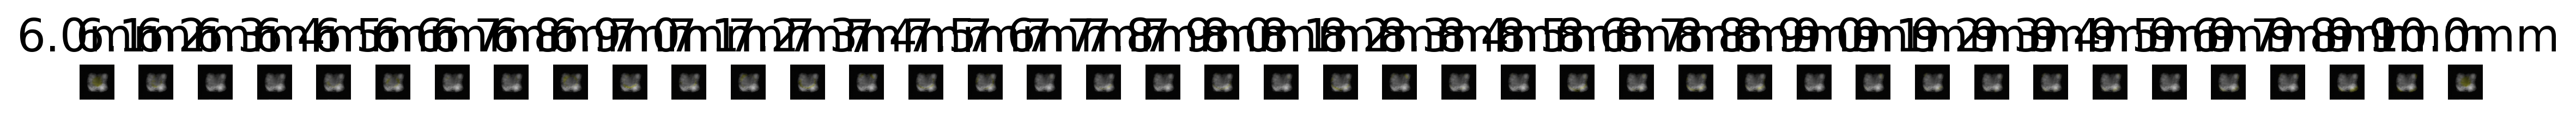

(1800, 1800, 41)

In [13]:
# Crop size 변수
fim_H, fim_W, Nz = np.shape(final_im)
fim_H_off = 0
fim_W_off = 0
imgplot_crop = (500,500)

# depth 값
# depths = [9.0, 9.4, 9.9, 10.4, 10.9, 11.4, 12.0] 
# depths = [9.0, 9.5, 10.1, 10.7, 11.3, 12.0, 12.1] 
# depths = [9.0, 9.7, 10.4, 11.2, 12.0] 
# depths = [9.0, 9.9, 10.9, 12.0, 12.1] 
depths = [6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9,10.0]

# data 180도 회전
# data = np.roll(np.rot90(np.copy(final_im),2), 0, axis=2)
data = np.copy(final_im)

# 1번째 열 figure plot
f1 = plt.figure(figsize=(15,5), dpi=300)
# 이미지 plot
for i in range(Nz):
    plt.subplot(1,Nz,i+1)
    img = data[...,i]
    imgplot = center_crop(img, (fim_H//2+fim_H_off, fim_W//2+fim_W_off), imgplot_crop)
    plt.imshow(imgplot, 'gray')
    plt.title(f"{depths[i]:.01f}mm", fontsize=20)   #depth 위치 Labeling
    plt.axis('off')
plt.tight_layout()
plt.show()


# 180도 회전
# data = np.roll(np.rot90(np.copy(final_im),2), 0, axis=2)
data = np.copy(final_im)
# 데이터 최소값을 0으로 맞춰 모든 값 양수되도록
data = data - np.min(data)

# 모든 depth마다의 이미지를 sum하여 2D 이미지로
summed = np.sum(data, axis=2)
# 2D 이미지 crop
summed_crop = center_crop(summed, (fim_H//2+fim_H_off, fim_W//2+fim_W_off), imgplot_crop)
imgplot = np.repeat(summed_crop[:, :, np.newaxis], 3, axis=2).astype(float)


# 2번째 열 figure plot
f2 = plt.figure(figsize=(15,5), dpi=300)
# Depth마다의 영역에 색칠
for i in range(Nz):
    # 합한 2D이미지 밝기를 70%로
    imgplot = np.repeat(summed_crop[:, :, np.newaxis], 3, axis=2).astype(float)*0.7
    plt.subplot(1,Nz,i+1)
    img = data[...,i]
    tmp = center_crop(img, (fim_H//2+fim_H_off, fim_W//2+fim_W_off), imgplot_crop)
    
    # 0,1,2 - R,G,B color 채널에서 tmp 이미지 빼서 영역 색 appear 
    # imgplot[...,0] = tmp
    # imgplot[...,0] = imgplot[...,0] - 0.5*tmp
    # imgplot[...,1] = imgplot[...,1] - 0.5*tmp
    imgplot[...,2] = imgplot[...,2] - tmp      # B channel 값이 상대적으로 작아져 R+G인 노란색
    #색상값 음수 방지
    imgplot = np.where(imgplot<0, 0,imgplot)
    imgplot = imgplot/np.max(imgplot)
    plt.imshow(imgplot, 'gray')
    plt.title(f"{depths[i]:.01f}mm", fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.show()

np.shape(data)

## 3D plot

선택된 depth index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
선택된 depth 값: [6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7
 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.  9.1 9.2 9.3 9.4 9.5
 9.6 9.7 9.8 9.9]


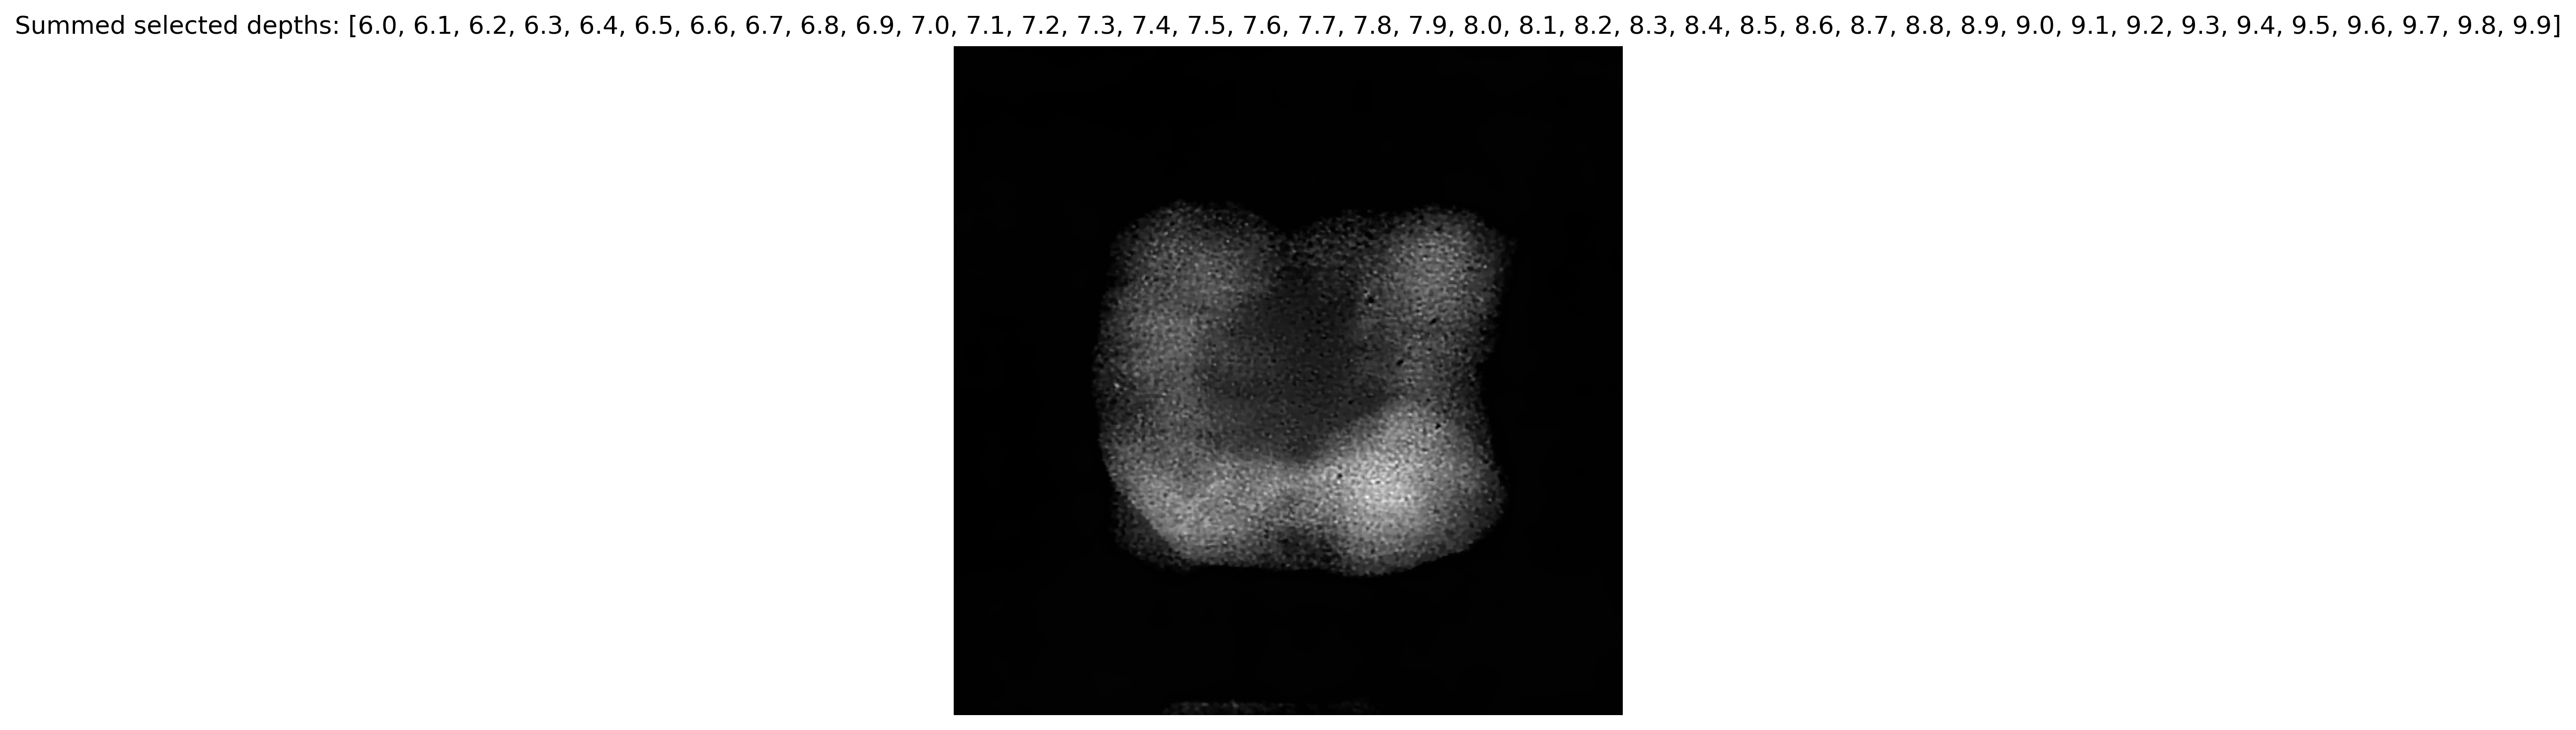

In [14]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

# final_im 불러온 상태라고 가정
# final_im.shape = (H, W, Nz)
data = np.copy(final_im)
data = data - np.min(data)  # 양수화

# 전체 depth 리스트 (이미 있으니 재사용)
depths = np.array([
    6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9,
    7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9,
    8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9,
    9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9
])

# ✅ 여기서 원하는 depth만 지정
# 예시: 6.0~8.0 구간만, 또는 임의 선택
selected_depths = [6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

# float 비교 오차 방지를 위해 isclose 사용
selected_mask = np.isclose(depths[:, None], np.array(selected_depths)[None, :], atol=1e-6).any(axis=1)
selected_indices = np.where(selected_mask)[0]

print("선택된 depth index:", selected_indices)
print("선택된 depth 값:", depths[selected_indices])

# 선택한 depth slice만 모아서 합치기
selected_data = data[..., selected_indices]          # (H, W, N_sel)
summed_sel = np.sum(selected_data, axis=2)          # (H, W)

# crop 설정
fim_H, fim_W, _ = data.shape
fim_H_off = 0
fim_W_off = 0
imgplot_crop = (500, 500)

def center_crop(img, center, size):
    ch, cw = center
    h, w = size
    y1 = ch - h//2
    y2 = ch + h//2
    x1 = cw - w//2
    x2 = cw + w//2
    return img[y1:y2, x1:x2]

summed_crop = center_crop(summed_sel, (fim_H//2 + fim_H_off, fim_W//2 + fim_W_off), imgplot_crop)

# 시각화
plt.figure(figsize=(5,5), dpi=300)
plt.imshow(summed_crop, cmap='gray')
plt.title(f"Summed selected depths: {selected_depths}")
plt.axis('off')
plt.tight_layout()
plt.show()


In [15]:
import matplotlib.pyplot as plt
import os

save_path = "/mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/_summed_whole_depths_raw_nolast.png"

# 정규화 후 저장 (0~1, grayscale)
norm = summed_crop - np.min(summed_crop)
if np.max(norm) > 0:
    norm = norm / np.max(norm)

plt.imsave(save_path, norm, cmap='gray')
print("Saved:", save_path)


Saved: /mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/_summed_whole_depths_raw_nolast.png


## Depth별 다른 색으로 전체 영역 cover

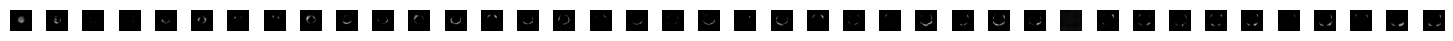

(40, 500, 500)


/tmp/ipykernel_922314/948393819.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name, N)


Saved RGB-only image to: /mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/270_7_depth_colormap_rgb_only.png
Saved RGB+colorbar figure to: /mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/270_7_depth_colormap_with_colorbar.png


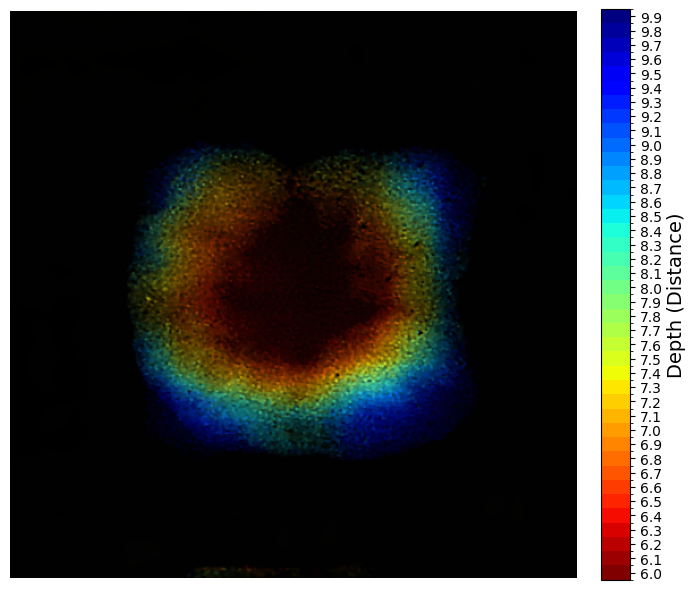

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm 

# ---------------------------------------------------------
# 1. Depth stack -> RGB image로 합치는 함수
# ---------------------------------------------------------
def create_rgb_image_from_depth_stack(image_stack, depths, colormap_name='jet_r'):
    """
    Combines N depth images into a single RGB image, assigning each depth a unique color.

    Args:
        image_stack (numpy.ndarray): (N, H, W) depth별 이미지 스택
        depths (list or array): 각 depth slice에 해당하는 실제 깊이 값 (길이 N)
        colormap_name (str): 사용할 colormap 이름 (예: 'jet_r' -> jet 반전)

    Returns:
        rgb_image (H, W, 3): depth 색이 섞인 RGB 이미지
        depth_colors (N, 3): 각 depth에 할당된 RGB 색
    """
    # 3차원인지 확인
    if image_stack.ndim != 3:
        raise ValueError("image_stack must be a 3D array of shape (N, H, W).")

    N, H, W = image_stack.shape

    if N != len(depths):
        raise ValueError(
            f"Number of depths ({len(depths)}) must match the number of depth images ({N})."
        )

    rgb_image = np.zeros((H, W, 3), dtype=np.float32)

    # 전체 스택을 0~1로 정규화
    vmin = image_stack.min()
    vmax = image_stack.max()
    if vmax <= vmin:
        normalized_stack = np.zeros_like(image_stack, dtype=np.float32)
    else:
        normalized_stack = (image_stack - vmin) / (vmax - vmin)

    # colormap에서 N개의 색 추출 (여기서 jet_r 사용 -> 낮은 값=red, 높은 값=blue)
    colormap = cm.get_cmap(colormap_name, N)
    depth_colors = colormap(np.linspace(0, 1, N))[:, :3]  # RGB만 사용

    # 각 depth slice에 색을 곱해서 누적
    for i in range(N):
        layer = normalized_stack[i]
        color = depth_colors[i]
        for c in range(3):
            rgb_image[:, :, c] += layer * color[c]

    # 최종 0~1 정규화
    max_val = np.max(rgb_image)
    if max_val > 0:
        rgb_image = rgb_image / max_val

    return rgb_image, depth_colors


# ---------------------------------------------------------
# 2. 3D 재구성 결과(final_im)에서 slice 뽑아서 image_stack 만들기
#    (final_im, Nz, fim_H, fim_W, fim_H_off, fim_W_off, imgplot_crop 은 이미 정의되어 있다고 가정)
# ---------------------------------------------------------

# 필요시 회전/flip
# data = np.roll(np.rot90(np.copy(final_im), 2), 0, axis=2)
data = np.copy(final_im)

plt.figure(figsize=(15, 5))
image_stack = []

for i in range(Nz-1):
    plt.subplot(1, Nz, i + 1)
    img = data[..., i]
    imgplot = center_crop(img, (fim_H // 2 + fim_H_off, fim_W // 2 + fim_W_off), imgplot_crop)
    image_stack.append(imgplot)
    plt.imshow(imgplot, 'gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# (N, H, W)
image_stack = np.array(image_stack)
print(image_stack.shape)

# depths: 예) np.linspace(6.0, 10.0, Nz) 등
depths = np.array(depths, dtype=float)
N = len(depths)
assert N == image_stack.shape[0], "depths 길이와 image_stack 첫 축(N)이 일치해야 합니다."


# ---------------------------------------------------------
# 3. RGB 합성 이미지 만들기 (jet_r 사용 -> 6.0=아래 빨강, 10.0=위 파랑)
# ---------------------------------------------------------
rgb_image, depth_colors = create_rgb_image_from_depth_stack(
    image_stack, depths, colormap_name='jet_r'  # jet_r가 포인트!
)

# ---------------------------------------------------------
# 4. RGB + colorbar 그리기
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_image)
ax.axis('off')

# colorbar용 colormap/정규화
custom_cmap = ListedColormap(depth_colors)  # depth 순서대로 색 N개
bounds = np.arange(N + 1)                   # [0,1,...,N]
norm = BoundaryNorm(bounds, N)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=ax,
    orientation='vertical',
    fraction=0.046,
    pad=0.04,
    boundaries=bounds,
    ticks=np.arange(N) + 0.5   # 각 구간 중앙에 tick
)

# tick label은 실제 depth 값
cbar.set_ticklabels([f"{d:.1f}" for d in depths])
cbar.set_label("Depth (Distance)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# 이 설정으로:
#  - depths[0] (예: 6.0) -> depth_colors[0] -> jet_r의 "낮은 값" = 빨강 = colorbar 아래쪽
#  - depths[-1] (예: 10.0) -> depth_colors[-1] -> jet_r의 "높은 값" = 파랑 = colorbar 위쪽

# ---------------------------------------------------------
# 5. 저장: (1) RGB만, (2) colorbar 포함 figure
# ---------------------------------------------------------
save_dir = "/mnt/NAS/Grants/25_AIOBIO/experiment/recon_2512/1205_1503_python/"
os.makedirs(save_dir, exist_ok=True)

# (1) RGB만 저장
rgb_only_path = os.path.join(save_dir, "270_7_depth_colormap_rgb_only.png")
plt.imsave(rgb_only_path, rgb_image)
print("Saved RGB-only image to:", rgb_only_path)

# (2) colorbar 포함 전체 figure 저장
fig_with_cb_path = os.path.join(save_dir, "270_7_depth_colormap_with_colorbar.png")
fig.savefig(fig_with_cb_path, bbox_inches='tight', dpi=300)
print("Saved RGB+colorbar figure to:", fig_with_cb_path)

plt.show()


In [39]:
print(image_stack.shape)

(40, 500, 500)
